# PYTS/BOSSVS classification algorithm test and measured accuracies
# Tested on transformed data

In [1]:
import numpy as np
from numpy import random
import pandas as pd
import re
import os
import matplotlib.pyplot as plt
import math
import sys 
import shutil
from keras.callbacks import CSVLogger
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from numpy import mean
from numpy import std
from numpy import dstack
from pandas import read_csv
from matplotlib import pyplot
from sklearn.model_selection import train_test_split
from sklearn.model_selection import ShuffleSplit # or StratifiedShuffleSplit
from pandas import DataFrame
import sktime
from sktime.classification.distance_based import KNeighborsTimeSeriesClassifier
from sklearn.metrics import f1_score

In [2]:
pathON="C:/Users/pierr/Documents_kanop/Shps/Pierre_points_for_louis/Bureau/interpo_ONOFF/Luigino/ON_data/"
pathOFF="C:/Users/pierr/Documents_kanop/Shps/Pierre_points_for_louis/Bureau/interpo_ONOFF/Luigino/OFF_data/"

In [3]:
#Storing in a list the adresses of all the data files in the notebook

data_files_ON=[]
file_names_ON=[]

data_files_OFF=[]
file_names_OFF=[]
data_files_ALL=[]
file_names_ALL=[]

#Storing in a list the adresses of all the data files in the notebook
for filename in os.listdir(pathOFF):
    f = os.path.join(pathOFF,filename)
    if os.path.isfile(f):
        data_files_OFF.append(f)
        file_names_OFF.append(filename)
        data_files_ALL.append(f)
        file_names_ALL.append(filename)
for filename in os.listdir(pathON):
    f = os.path.join(pathON,filename)
    if os.path.isfile(f):
        data_files_ON.append(f)
        file_names_ON.append(filename)
        data_files_ALL.append(f)
        file_names_ALL.append(filename)       

In [4]:
#Using data_files with only the 36 binning
Filter=True
binning=37


if Filter==True:
    
    idx_OFF=[]
    idx_ON=[]
    dataON=[]
    dataOFF=[]
    for i in range(len(data_files_OFF)):
        dataframe = pd.read_csv(data_files_OFF[i])
        lg = len(dataframe)
        
        if lg==binning:
            idx_OFF.append(i)
    
    for i in range(len(data_files_ON)):
        dataframe = pd.read_csv(data_files_ON[i])
        lg = len(dataframe)

        if lg==binning:
            idx_ON.append(i)


    for i in range(len(idx_OFF)):

        a=idx_OFF[i]
        dataOFF.append(data_files_OFF[a])
    for i in range(len(idx_ON)):

        a=idx_ON[i]
        dataON.append(data_files_ON[a])

idx = idx_OFF+idx_ON


In [5]:
from pyts.classification import BOSSVS
from pyts.multivariate.classification import MultivariateClassifier

iteration=25
lgON=len(dataON)
lgOFF=len(dataOFF)
lg=lgON+lgOFF
Labels = []
ON_accuracy=[]
OFF_accuracy=[]
fscore=[]
FPOS=[]
FNEG= []
Q_ON=[]
nbfeatures=1
nb_dels=0
a=binning-nb_dels
b=nbfeatures

c=lg

# multivariate



lgON=len(dataON)
lgOFF=len(dataOFF)
lg=lgON+lgOFF
Labels = []

nbfeatures=1

a=binning
b=nbfeatures
c=lg

# multivariate

data_matrix= np.zeros((c,b,a))

#Construct data matrix
for j in range(len(dataOFF)):

    dataframe=pd.read_csv(dataOFF[j],index_col=[0])
    dataframe.columns=['MJD','Flux','Delta Flux','Photon Index','Delta Index','TS','fratio']

    data_matrix[j][0]=dataframe['Flux']
#     data_matrix[j][0]=dataframe['Photon Index']*dataframe['Flux']
#     data_matrix[j][1]=dataframe['Photon Index']
#     data_matrix[j][1]=dataframe['TS']
#     data_matrix[j][2]=dataframe['fratio']

for j in range(len(dataON)):

    v=j+len(dataOFF)
    dataframe=pd.read_csv(dataON[j],index_col=[0])
    dataframe.columns=['MJD','Flux','Delta Flux','Photon Index','Delta Index','TS','fratio']

    data_matrix[v][0]=dataframe['Flux']
#     data_matrix[v][0]=dataframe['Photon Index']*dataframe['Flux']
#     data_matrix[v][1]=dataframe['Photon Index']  
#     data_matrix[v][1]=dataframe['TS']
#     data_matrix[v][2]=dataframe['fratio']

#Creating labels
for i in range(lgOFF):
    
    Labels.append(int(0))
    
for i in range(lgON):
    Labels.append(int(1))


data_matrix=data_matrix.reshape((c,a)) 

for i in range(iteration):
    
    #3D shape of data, multivariate time series

    sss = ShuffleSplit(n_splits=1, test_size=0.2,random_state=i)
    X=data_matrix
    y=Labels

    sss.get_n_splits(X, y)
    train_index, test_index = next(sss.split(X, y)) 

    x_train, x_test = X[train_index], X[test_index] 

    y_train=[]
    y_test=[]

    for i in range(len(train_index)):
        a=train_index[i]
        y_train.append(y[a])
    for i in range(len(test_index)):

        a=test_index[i]
        y_test.append(y[a])

    y_test2=y_test.copy()

    clf = BOSSVS()
    clf.fit(x_train, y_train)
    clf.predict(x_test)

    prediction=np.array(clf.predict(x_test))
    on_score=0
    on_nbs=0
    off_nbs=0
    off_score=0
    foff=0
    fon=0
    for i in range(len(y_test)):
        if y_test2[i]==1 :
            on_nbs+=1
            if prediction[i]==1:
                on_score+=1
                a=test_index[i]
                Q_ON.append(a)
            else : 
                fon+=1
        if y_test2[i]==0 :
            off_nbs+=1
            if prediction[i]==0:
                off_score+=1 
            else:
                foff+=1
                a=test_index[i]
                Q_ON.append(a)
    if on_nbs>0:    
        ON_accuracy.append(100*(on_score/on_nbs))
        FPOS.append(100*(fon/on_nbs))
    OFF_accuracy.append(100*(off_score/off_nbs))
    FNEG.append(100*(foff/off_nbs))
    f1= f1_score(y_test2,prediction)
    fscore.append(f1)
    
print("Accuracy for ON class: ",np.mean(ON_accuracy) ,"%")
print("Accuracy for OFF class: ",np.mean(OFF_accuracy) ,"%")
print("False Positive rate: ",np.mean(FPOS) ,"%")
print("False Negative rate: ",np.mean(FNEG) ,"%")
print("F1 score: ",np.mean(fscore))



# gg = np.unique(Q_ON)
# Q_ON2=[]
# Q_ON3=[]
# errOFF=[]



# if len(gg)>0:
#     for i in range(len(Q_ON)):
#         aa=Q_ON[i]
#         Q_ON2.append(file_names_ALL[aa])
#     gg = np.unique(Q_ON2)    
#     for i in range(len(gg)):
#         bb=gg[i]
#         count = Q_ON2.count(bb)
#         if count>int(iteration/7):
#             Q_ON3.append([bb,count])
#             errOFF.append(bb)
# print(Q_ON3)


Accuracy for ON class:  75.05658315380437 %
Accuracy for OFF class:  28.28780604246573 %
False Positive rate:  24.943416846195635 %
False Negative rate:  71.71219395753427 %
F1 score:  0.20186991303563973
[['4FGL J0238+1637.csv', 6], ['4FGL J0239+0415.csv', 4], ['4FGL J0242+1102.csv', 8], ['4FGL J0242+5216.csv', 4], ['4FGL J0253+3216.csv', 5], ['4FGL J0253+5103.csv', 4], ['4FGL J0257-1215.csv', 5], ['4FGL J0303+4716.csv', 6], ['4FGL J0315-1033.csv', 4], ['4FGL J0326+0225.csv', 4], ['4FGL J0331+6307.csv', 8], ['4FGL J0339-1736.csv', 4], ['4FGL J0349-1159.csv', 5], ['4FGL J0349-2103.csv', 5], ['4FGL J0354+8009.csv', 6], ['4FGL J0359+5057.csv', 8], ['4FGL J0401+2112.csv', 4], ['4FGL J0401-2034.csv', 9], ['4FGL J0405-1308.csv', 6], ['4FGL J0407+0741.csv', 4], ['4FGL J0416-1852.csv', 5], ['4FGL J0418+3807.csv', 5], ['4FGL J0423+4150.csv', 6], ['4FGL J0423-0120.csv', 8], ['4FGL J0426+6826.csv', 5], ['4FGL J0429+2843.csv', 6], ['4FGL J0430+1654.csv', 6], ['4FGL J0431+7403.csv', 9], ['4FGL J04

In [10]:
dens = clf.decision_function(x_test)

print(dens)

OFFF=[]
ONN=[]
idx_ON=[]
idx_OFF=[]
for i in range(len(y_test)):
    
    if y_test[i]==1:
        idx_ON.append(i)
    if y_test[i]==0:
        idx_OFF.append(i)        

         
for i in range(len(dens)):
        
        OFFF.append(dens[i][0])
        ONN.append(dens[i][1])
        
ONN_true=[ONN[j] for j in idx_ON]
OFF_true=[ONN[j] for j in idx_OFF]

print(ONN_true)

[[0.26202368 0.29163251]
 [0.2888862  0.2839594 ]
 [0.36661118 0.41270365]
 [0.33131283 0.32168074]
 [0.29823289 0.30157972]
 [0.28579571 0.34680645]
 [0.30869476 0.29291317]
 [0.34221909 0.33805983]
 [0.31091269 0.32341462]
 [0.33467195 0.38474452]
 [0.3034132  0.32925128]
 [0.33601606 0.34148828]
 [0.34470315 0.36686058]
 [0.27000437 0.32481947]
 [0.30040255 0.28569066]
 [0.34393928 0.35495001]
 [0.3485598  0.37251998]
 [0.23474295 0.29707179]
 [0.33051908 0.33364109]
 [0.33614648 0.33989944]
 [0.31440119 0.30966353]
 [0.3389327  0.37457706]
 [0.2294618  0.2973542 ]
 [0.27131237 0.27372922]
 [0.31299348 0.31138334]
 [0.29915406 0.30646185]
 [0.331787   0.33314948]
 [0.33652762 0.34425359]
 [0.32369378 0.33901158]
 [0.30755377 0.31399861]
 [0.33802923 0.31574072]
 [0.25477835 0.25562249]
 [0.34204799 0.34157131]
 [0.31785734 0.31325803]
 [0.26835317 0.32088647]
 [0.2979457  0.34570748]
 [0.32743794 0.32079758]
 [0.28934912 0.28505518]
 [0.30983669 0.29315912]
 [0.30625468 0.31848534]


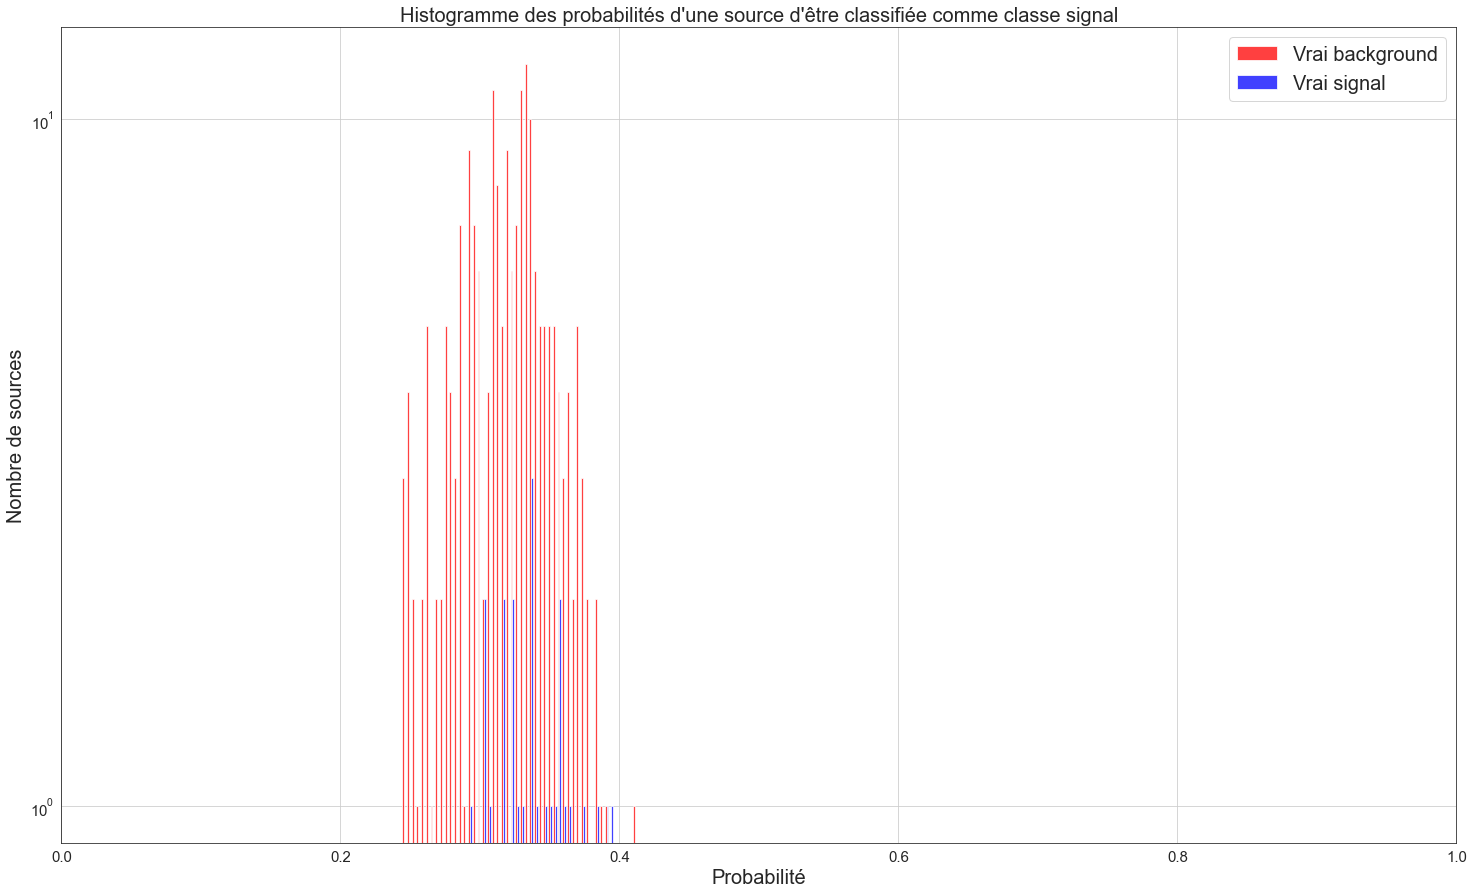

In [11]:
import seaborn as sns
sns.set_style("white")

# Plotting  model score distribution

#kwargs = dict(hist_kws={'alpha':.6}, kde_kws={'linewidth':2})

colors = ['r','b']
labels=['Vrai background','Vrai signal']
fig = plt.figure(figsize=(25,15))
# ax1 = fig1.add_subplot(121)
plt.hist([OFF_true,ONN_true],50,color=colors,label=labels,alpha=0.75)
plt.xlabel("Probabilité",fontsize=20)
plt.ylabel("Nombre de sources",fontsize=20)
plt.title("Histogramme des probabilités d'une source d'être classifiée comme classe signal",fontsize=20)
#ax1.hist(OFF_true,20,color="r", label="Prob of being ON for all LC",density=True,alpha=0.75)
#ax1.hist(ONN_true,20,color="b", label="Prob of being ON for all LC",density=True,alpha=0.75)

#sns.distplot(ONN, color="g", label="Prob of beiung ON for all LC")
#sns.distplot(OFF_true, color="r", label="Prob of being ON for OFF LC")

plt.xlim(0,1)
plt.xticks(fontsize = 15)
plt.yticks(fontsize = 15)
#sns.distplot(ONN, color="dodgerblue", label="Prob ON")
#sns.distplot(OFFF, color="orange", label="OFF")
#plt.title("Score density")
plt.yscale('log')
#plt.xlim(0,1)
#plt.ylim(0.01,800)
plt.grid()

plt.legend(fontsize=20);

In [55]:
#Storing in a list the adresses of all the data files in the notebook

data_files_ON=[]
file_names_ON=[]

data_files_OFF=[]
file_names_OFF=[]
data_files_ALL=[]
file_names_ALL=[]

#Storing in a list the adresses of all the data files in the notebook
for filename in os.listdir(pathOFF):
    f = os.path.join(pathOFF,filename)
    if os.path.isfile(f) and filename in errOFF :
        data_files_OFF.append(f)
        file_names_OFF.append(filename)
        data_files_ALL.append(f)
        file_names_ALL.append(filename)
        
for filename in os.listdir(pathON):
    f = os.path.join(pathON,filename)
    if os.path.isfile(f):
        data_files_ON.append(f)
        file_names_ON.append(filename)
        data_files_ALL.append(f)
        file_names_ALL.append(filename)       

In [56]:
#Using data_files with only the 36 binning
Filter=True
binning=37


if Filter==True:
    
    idx_OFF=[]
    idx_ON=[]
    dataON=[]
    dataOFF=[]
    for i in range(len(data_files_OFF)):
        dataframe = pd.read_csv(data_files_OFF[i])
        lg = len(dataframe)
        
        if lg==binning:
            idx_OFF.append(i)
    
    for i in range(len(data_files_ON)):
        dataframe = pd.read_csv(data_files_ON[i])
        lg = len(dataframe)

        if lg==binning:
            idx_ON.append(i)


    for i in range(len(idx_OFF)):

        a=idx_OFF[i]
        dataOFF.append(data_files_OFF[a])
    for i in range(len(idx_ON)):

        a=idx_ON[i]
        dataON.append(data_files_ON[a])

idx = idx_OFF+idx_ON

In [57]:

from pyts.classification import BOSSVS
from pyts.multivariate.classification import MultivariateClassifier

iteration=200
lgON=len(dataON)
lgOFF=len(dataOFF)
lg=lgON+lgOFF

binning=37

Labels = []
Q_ON= []

nbfeatures=3
ON_accuracy=[]
OFF_accuracy=[]
fscore=[]
FPOS=[]
FNEG=[]
a=binning
b=nbfeatures
c=len(data_files_ALL)

# multivariate
y=np.zeros((2,lg))
bigdata= np.zeros((b,c,a))

for j in range(len(data_files_ALL)):

    dataframe=pd.read_csv(data_files_ALL[j],index_col=[0])
    dataframe.columns=['MJD','Flux','Delta Flux','Photon Index','Delta Index','TS','fratio']

    bigdata[0][j]=dataframe['Flux']
    bigdata[1][j]=dataframe['Photon Index']*dataframe['Flux']
    bigdata[2][j]=dataframe['Photon Index']

for i in range(lgOFF):
    
    Labels.append(int(0))
    
for i in range(lgON): 
    
    
    Labels.append(int(1))
    
    
bigdata=bigdata.reshape(c,nbfeatures,binning)    
print(bigdata.shape)
for i in range(iteration):
    
    #3D shape of data, multivariate time series

    sss = ShuffleSplit(n_splits=1, test_size=0.2,random_state=i)
    X=bigdata
    y=Labels

    sss.get_n_splits(X, y)
    train_index, test_index = next(sss.split(X, y)) 

    x_train, x_test = X[train_index], X[test_index] 

    y_train=[]
    y_test=[]

    for i in range(len(train_index)):
        a=train_index[i]
        y_train.append(y[a])
    for i in range(len(test_index)):

        a=test_index[i]
        y_test.append(y[a])

    y_test2=y_test.copy()

    clf = MultivariateClassifier(BOSSVS(n_bins=5,anova=True,word_size=9,drop_sum=True))
    clf.fit(x_train, y_train)
    MultivariateClassifier(...)
    clf.predict(x_test)

    prediction=np.array(clf.predict(x_test))
    on_score=0
    on_nbs=0
    off_nbs=0
    off_score=0
    foff=0
    fon=0
    for i in range(len(y_test)):
        if y_test2[i]==1 :
            on_nbs+=1
            if prediction[i]==1:
                on_score+=1
            else : 
                fon+=1
        if y_test2[i]==0 :
            off_nbs+=1
            if prediction[i]==0:
                off_score+=1 
            else:
                foff+=1
                a=test_index[i]
                Q_ON.append(a)
    if on_nbs>0:    
        ON_accuracy.append(100*(on_score/on_nbs))
        FPOS.append(100*(fon/on_nbs))
    OFF_accuracy.append(100*(off_score/off_nbs))
    FNEG.append(100*(foff/off_nbs))
    f1= f1_score(y_test2,prediction,average='weighted')
    fscore.append(f1)
    
print("Accuracy for ON class: ",np.mean(ON_accuracy) ,"%")
print("Accuracy for OFF class: ",np.mean(OFF_accuracy) ,"%")
print("False Positive rate: ",np.mean(FPOS) ,"%")
print("False Negative rate: ",np.mean(FNEG) ,"%")
print("F1 score: ",np.mean(fscore))



gg = np.unique(Q_ON)
Q_ON2=[]
Q_ON3=[]
errOFF=[]
print(len(test_index))
print(len(np.unique(Q_ON)))

if len(gg)>0:
    for i in range(len(Q_ON)):
        aa=Q_ON[i]
        Q_ON2.append(file_names_ALL[aa])
    gg = np.unique(Q_ON2)    
    for i in range(len(gg)):
        bb=gg[i]
        count = Q_ON2.count(bb)
        if count>int(iteration/8):
            Q_ON3.append([bb,count])
            errOFF.append(bb)
print(Q_ON3)

(366, 3, 37)
Accuracy for ON class:  100.0 %
Accuracy for OFF class:  93.19517316169927 %
False Positive rate:  0.0 %
False Negative rate:  6.80482683830072 %
F1 score:  0.9532897723752309
74
24
[['4FGLJ0047+2233.csv', 36], ['4FGLJ0203+7233.csv', 44], ['4FGLJ0205-1700.csv', 40], ['4FGLJ0209+4449.csv', 42], ['4FGLJ0209+7229.csv', 44], ['4FGLJ0211+1051.csv', 39], ['4FGLJ0212+2244.csv', 47], ['4FGLJ0214+5145.csv', 42], ['4FGLJ0215+0300.csv', 34], ['4FGLJ0216+2313.csv', 41], ['4FGLJ0216-1015.csv', 41], ['4FGLJ0217+0837.csv', 38], ['4FGLJ0217+7352.csv', 42], ['4FGLJ0217-0821.csv', 45], ['4FGLJ0219+2443.csv', 41], ['4FGLJ0219-1724.csv', 35]]


In [58]:
#Storing in a list the adresses of all the data files in the notebook

data_files_ON=[]
file_names_ON=[]

data_files_OFF=[]
file_names_OFF=[]
data_files_ALL=[]
file_names_ALL=[]

#Storing in a list the adresses of all the data files in the notebook
for filename in os.listdir(pathOFF):
    f = os.path.join(pathOFF,filename)
    if os.path.isfile(f) and filename in errOFF :
        data_files_OFF.append(f)
        file_names_OFF.append(filename)
        data_files_ALL.append(f)
        file_names_ALL.append(filename)
        
for filename in os.listdir(pathON):
    f = os.path.join(pathON,filename)
    if os.path.isfile(f):
        data_files_ON.append(f)
        file_names_ON.append(filename)
        data_files_ALL.append(f)
        file_names_ALL.append(filename)

In [59]:
#Using data_files with only the 36 binning
Filter=True
binning=37


if Filter==True:
    
    idx_OFF=[]
    idx_ON=[]
    dataON=[]
    dataOFF=[]
    for i in range(len(data_files_OFF)):
        dataframe = pd.read_csv(data_files_OFF[i])
        lg = len(dataframe)
        
        if lg==binning:
            idx_OFF.append(i)
    
    for i in range(len(data_files_ON)):
        dataframe = pd.read_csv(data_files_ON[i])
        lg = len(dataframe)

        if lg==binning:
            idx_ON.append(i)


    for i in range(len(idx_OFF)):

        a=idx_OFF[i]
        dataOFF.append(data_files_OFF[a])
    for i in range(len(idx_ON)):

        a=idx_ON[i]
        dataON.append(data_files_ON[a])

idx = idx_OFF+idx_ON

In [60]:

from pyts.classification import BOSSVS
from pyts.multivariate.classification import MultivariateClassifier

iteration=200
lgON=len(dataON)
lgOFF=len(dataOFF)
lg=lgON+lgOFF

binning=37

Labels = []
Q_ON= []

nbfeatures=3
ON_accuracy=[]
OFF_accuracy=[]
fscore= []
FPOS=[]
FNEG=[]
a=binning
b=nbfeatures
c=len(data_files_ALL)

# multivariate
y=np.zeros((2,lg))
bigdata= np.zeros((b,c,a))

for j in range(len(data_files_ALL)):

#         a=Q_ON2[j]

    dataframe=pd.read_csv(data_files_ALL[j],index_col=[0])
    dataframe.columns=['MJD','Flux','Delta Flux','Photon Index','Delta Index','TS','fratio']

    bigdata[0][j]=dataframe['Flux']
    bigdata[1][j]=dataframe['Photon Index']*dataframe['Flux']
    bigdata[2][j]=dataframe['Photon Index']

for i in range(lgOFF):
    
    Labels.append(int(0))
    
for i in range(lgON): 
    
    
    Labels.append(int(1))
    
    
bigdata=bigdata.reshape(c,nbfeatures,binning)    
print(bigdata.shape)
for i in range(iteration):
    #3D shape of data, multivariate time series

    sss = ShuffleSplit(n_splits=1, test_size=0.2,random_state=i)
    X=bigdata
    y=Labels

    sss.get_n_splits(X, y)
    train_index, test_index = next(sss.split(X, y)) 

    x_train, x_test = X[train_index], X[test_index] 

    y_train=[]
    y_test=[]

    for i in range(len(train_index)):
        a=train_index[i]
        y_train.append(y[a])
    for i in range(len(test_index)):

        a=test_index[i]
        y_test.append(y[a])

    y_test2=y_test.copy()

    clf = MultivariateClassifier(BOSSVS(n_bins=5,anova=True,word_size=9,drop_sum=True))
    clf.fit(x_train, y_train)
    MultivariateClassifier(...)
    clf.predict(x_test)

    prediction=np.array(clf.predict(x_test))
    on_score=0
    on_nbs=0
    off_nbs=0
    off_score=0
    foff=0
    fon=0
    for i in range(len(y_test)):
        if y_test2[i]==1 :
            on_nbs+=1
            if prediction[i]==1:
                on_score+=1
            else : 
                fon+=1
        if y_test2[i]==0 :
            off_nbs+=1
            if prediction[i]==0:
                off_score+=1 
            else:
                foff+=1
                a=test_index[i]
                Q_ON.append(a)
    if on_nbs>0:    
        ON_accuracy.append(100*(on_score/on_nbs))
        FPOS.append(100*(fon/on_nbs))
    OFF_accuracy.append(100*(off_score/off_nbs))
    FNEG.append(100*(foff/off_nbs))
    f1= f1_score(y_test2,prediction,average='weighted')
    fscore.append(f1)
    
print("Accuracy for ON class: ",np.mean(ON_accuracy) ,"%")
print("Accuracy for OFF class: ",np.mean(OFF_accuracy) ,"%")
print("False Positive rate: ",np.mean(FPOS) ,"%")
print("False Negative rate: ",np.mean(FNEG) ,"%")
print("F1 score: ",np.mean(fscore))


gg = np.unique(Q_ON)
Q_ON2=[]
Q_ON3=[]
errOFF=[]

if len(gg)>0:
    for i in range(len(Q_ON)):
        aa=Q_ON[i]
        Q_ON2.append(file_names_ALL[aa])
    gg = np.unique(Q_ON2)    
    for i in range(len(gg)):
        bb=gg[i]
        count = Q_ON2.count(bb)
        if count>int(iteration/5):
            Q_ON3.append([bb,count])
            errOFF.append(bb)
print(Q_ON3)

(124, 3, 37)


ZeroDivisionError: division by zero

In [ ]:
#Storing in a list the adresses of all the data files in the notebook

data_files_ON=[]
file_names_ON=[]

data_files_OFF=[]
file_names_OFF=[]
data_files_ALL=[]
file_names_ALL=[]

#Storing in a list the adresses of all the data files in the notebook
for filename in os.listdir(pathOFF):
    f = os.path.join(pathOFF,filename)
    if os.path.isfile(f) and filename in errOFF :
        data_files_OFF.append(f)
        file_names_OFF.append(filename)
        data_files_ALL.append(f)
        file_names_ALL.append(filename)
        
for filename in os.listdir(pathON):
    f = os.path.join(pathON,filename)
    if os.path.isfile(f):
        data_files_ON.append(f)
        file_names_ON.append(filename)
        data_files_ALL.append(f)
        file_names_ALL.append(filename)

In [ ]:
#Using data_files with only the 36 binning
Filter=True
binning=37


if Filter==True:
    
    idx_OFF=[]
    idx_ON=[]
    dataON=[]
    dataOFF=[]
    
    for i in range(len(data_files_OFF)):
        dataframe = pd.read_csv(data_files_OFF[i])
        lg = len(dataframe)
        
        if lg==binning:
            idx_OFF.append(i)
    
    for i in range(len(data_files_ON)):
        dataframe = pd.read_csv(data_files_ON[i])
        lg = len(dataframe)

        if lg==binning:
            idx_ON.append(i)


    for i in range(len(idx_OFF)):

        a=idx_OFF[i]
        dataOFF.append(data_files_OFF[a])
    for i in range(len(idx_ON)):

        a=idx_ON[i]
        dataON.append(data_files_ON[a])

idx = idx_OFF+idx_ON

In [ ]:

from pyts.classification import BOSSVS
from pyts.multivariate.classification import MultivariateClassifier

iteration=200
lgON=len(dataON)
lgOFF=len(dataOFF)
lg=lgON+lgOFF

binning=37

Labels = []
Q_ON= []

nbfeatures=3
ON_accuracy=[]
OFF_accuracy=[]
fscore=[]
FPOS=[]
FNEG=[]
a=binning
b=nbfeatures
c=len(data_files_ALL)

# multivariate
y=np.zeros((2,lg))
bigdata= np.zeros((b,c,a))

for j in range(len(data_files_ALL)):


    dataframe=pd.read_csv(data_files_ALL[j])
    dataframe.columns=['Iteration2','Iteration','MJD','Flux','Delta Flux','Photon Index','Delta Index','TS','fratio']

    bigdata[0][j]=dataframe['Flux']
    bigdata[1][j]=dataframe['Photon Index']*dataframe['Flux']
    bigdata[2][j]=dataframe['Photon Index']

for i in range(lgOFF):
    
    Labels.append(int(0))
    
for i in range(lgON): 
    
    
    Labels.append(int(1))
    
    
bigdata=bigdata.reshape(c,nbfeatures,binning)    
print(bigdata.shape)
for i in range(iteration):
    #3D shape of data, multivariate time series

    sss = ShuffleSplit(n_splits=1, test_size=0.2,random_state=i)
    X=bigdata
    y=Labels

    sss.get_n_splits(X, y)
    train_index, test_index = next(sss.split(X, y)) 

    x_train, x_test = X[train_index], X[test_index] 

    y_train=[]
    y_test=[]

    for i in range(len(train_index)):
        a=train_index[i]
        y_train.append(y[a])
    for i in range(len(test_index)):

        a=test_index[i]
        y_test.append(y[a])

    y_test2=y_test.copy()

    clf = MultivariateClassifier(BOSSVS(n_bins=5,anova=True,word_size=9,drop_sum=True))
    clf.fit(x_train, y_train)
    MultivariateClassifier(...)
    clf.predict(x_test)

    prediction=np.array(clf.predict(x_test))
    on_score=0
    on_nbs=0
    off_nbs=0
    off_score=0
    foff=0
    fon=0
    for i in range(len(y_test)):
        if y_test2[i]==1 :
            on_nbs+=1
            if prediction[i]==1:
                on_score+=1
            else : 
                fon+=1
        if y_test2[i]==0 :
            off_nbs+=1
            if prediction[i]==0:
                off_score+=1 
            else:
                foff+=1
    if on_nbs>0:    
        ON_accuracy.append(100*(on_score/on_nbs))
        FPOS.append(100*(fon/on_nbs))
    OFF_accuracy.append(100*(off_score/off_nbs))
    FNEG.append(100*(foff/off_nbs))
    f1= f1_score(y_test2,prediction,average='weighted')
    fscore.append(f1)
    
print("Accuracy for ON class: ",np.mean(ON_accuracy) ,"%")
print("Accuracy for OFF class: ",np.mean(OFF_accuracy) ,"%")
print("False Positive rate: ",np.mean(FPOS) ,"%")
print("False Negative rate: ",np.mean(FNEG) ,"%")
print("F1 score: ",np.mean(fscore))



gg = np.unique(Q_ON)
Q_ON2=[]
Q_ON3=[]
errOFF=[]

if len(gg)>0:
    for i in range(len(Q_ON)):
        aa=Q_ON[i]
        Q_ON2.append(file_names_ALL[aa])
    gg = np.unique(Q_ON2)    
    for i in range(len(gg)):
        bb=gg[i]
        count = Q_ON2.count(bb)
        if count>1:
            Q_ON3.append([bb,count])
            errOFF.append(bb)
print(Q_ON3)